In [2]:
import astropy
from astropy import units
from astropy.coordinates import SkyCoord
import numpy
from matplotlib import pyplot

First get coordinates from Ae aur and Mu Col. Using data from Gaia Dr2 

In [3]:
#lonlat = ["5h16m18.15s +34d18m44.0s", " 5h45m59.89s -32d18m44.0s"]
ra = [79.07559745673318,86.49957923452477 ]*units.deg
dec = [34.312505337886705,-32.30652949616978 ]*units.deg
pmra = [ -4.4396,2.9881]#units.mas/units.yr 
pmdec = [43.36777,-22.02968]#*units.mas/units.yr
parallax = [2.24,2.52]
radial_velocity = [57.5,109.0]
coords = SkyCoord(#lonlat,unit=(units.hourangle,units.deg)                 
                ra = ra, dec=dec
                ,pm_ra_cosdec = pmra* units.mas/units.yr, pm_dec = pmdec* units.mas/units.yr                   
                ,distance = numpy.clip(1000.0/numpy.array(parallax),0,1E5 )*units.parsec 
                ,radial_velocity=radial_velocity*units.km/units.s                       
                ,obstime="J1991.25")
coords = coords.galactic
print(coords)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(172.08115261,  -2.25914075, 446.42857143),
     (237.28627192, -27.10208942, 396.82539683)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-37.91870614, 21.50918984,  57.5),
     ( 21.97672422, -3.35546347, 109. )]>


Following function corrects for solar peculiar motion. It just substract the projected solar proper motion in the given star.
The equation for correcting the radial velocity is also there but not used.

In [4]:
def correct_gpm(l,b,pmlstar,pmb,distance):
    u_s,v_s,w_s=[11.1,12.24,7.25] * units.km/units.s #Schronich+2010
    cos = numpy.cos
    sin = numpy.sin
    
    vrad_solm = ( -u_s*cos(l)*cos(b) - v_s*sin(l)*cos(b) - w_s*cos(b) )         
    pml_solm  = ( u_s*sin(l)-v_s*cos(l) )/cos(b)*units.rad/distance                 
    pmb_solm  = ( u_s*cos(l)*sin(b) + v_s*sin(l)*sin(b) - w_s*cos(b) )*units.rad/distance

    
    pml_c = pmlstar/cos(b) - pml_solm                              
    pmb_c = pmb - pmb_solm
            
    return pml_c,pmb_c
    #return pmlstar/numpy.cos(b), pmb

Below I show how I use above functions to calculate trajectories.
First defining a function to compute the full trajectory on the celestial sphere, and also associate a time for 
each point assuming the proper motion do not change with time. 

This trajectory would give a complete circle around the celestial sphere. But of course we only use a fraction of that trajectory.

Then, the resulting traceback times are not correct, since proper motions change with time because of the projection on the celestial sphere. These times are used just as reference, only a 3D traceback gives the right traceback time.

In [5]:
def great_circles_trajectory(l,b,pmlc,pmbc,N=100,with_time=False,
                             limits=None,start_from_star=True):
    """ Computes the complete trajectory over the surface of the celestial sphere in straigth line 
    neeeds coordinates and pm : l,b, and propermotions pml,pmb                  
    N : the number of points to sample                                          
    proper motions should be corrected by solar motion    
                                                                                
    """                                                                         
                                                          
    array_like = hasattr(l.value,"__len__")                                 
    if limits is not None:                                                      
        limits = limits.to_value(units.degree)                                      
    else:                                                                       
        limits = [0,360]                                                        
                                                                                
    if array_like:                                                              
        ### reshaping for array arithmetic                                      
        ### variables capital letters have shapes (len(l),N)          
        ### Then each row contains the trajectory of the corresponding particle
        Lsample = numpy.array([ numpy.linspace(limits[0],limits[1],N) ]*len(l)) * units.deg
                                                                                                                                      
        L  = numpy.array([l.value]*N).transpose() * l.unit                      
        B  = numpy.array([b.value]*N).transpose() * b.unit                      
        PML  = numpy.array([pmlc.value]*N).transpose() * pmlc.unit                 
        PMB  = numpy.array([pmbc.value]*N).transpose() * pmbc.unit              
        toflip = pmlc > 0  # inverse trajectory of stars with positive propermotion (we are looking back)
        if start_from_star :                                                    
            Lsample = Lsample + L # The starting point of the trajectory should be the position of the star
        Lsample[toflip] = Lsample[toflip,::-1] #do the inversion on selected particles
                                                                                                        
        axis = 1
    else:                                                                       
        Lsample = (numpy.linspace(limits[0],limits[1],N) * units.deg)               
        if start_from_star:                                                     
            Lsample+=l                                                          
        if (pmlc > 0 ):                                                         
            Lsample = Lsample[::-1]                                             
        L,B = l,b                                                               
        PML,PMB  = pmlc,pmbc
        
        axis = 0                                                                
                                                                                
    Lsample = numpy.remainder( Lsample.to_value(units.deg),360) * units.deg #convert values above 360 to periodic
    
    ## Lsample will follow the (past) trajectory starting from the location of each star
    ## flip is necessary for the stars with positive proper motions so the past trajectory goes in the opossite direction
    ## This is important for later when associating a time to each point in the trajectory
    NUM1 = PML*numpy.cos(B)*numpy.sin(B)*numpy.cos(Lsample-L)                         
    NUM2 = PMB*numpy.sin(Lsample-L)                                                   
    DEN  = PML*(numpy.cos(B) )**2                                               
                                                
                                                                                
    TGBSAMPLE = (NUM1+NUM2)/DEN                                                 
    Bsample = numpy.arctan(TGBSAMPLE).to(units.deg)                                 
    if not with_time:                                                           
        return Lsample, Bsample                                             
    else:                                                                       
        #assosiate a time for each point in trajectory                                                             
        pm = numpy.sqrt(PML**2 + (PMB)**2)                                  
        #pm = numpy.sqrt( (PML*cos(Bsample) )**2 + (PMB)**2)                
        L2 = numpy.roll(Lsample,1,axis=axis)                                
        B2 = numpy.roll(Bsample,1,axis=axis)                                
        THETA = great_circle_distance(Lsample,Bsample,L2,B2)                
        #THETA = great_circle_distance(Lsample,Bsample,L,B)                 
        THETA = numpy.nancumsum(THETA,axis=axis)                            
        Tsample = (THETA/pm).to(units.year)                                     
        return Lsample,Bsample,Tsample #Tsample have units
            

Following function is just the great circle distance between 2 points.


In [7]:
def great_circle_distance(l1,b1,l0,b0):                                         
    " returns great circle distance between two points"                         
    term1   = numpy.sin(b0)*numpy.sin(b1)                                                   
    term2   = numpy.cos(b0)*numpy.cos(b1)*numpy.cos(l1-l0)                                        
    return numpy.arccos( term1 + term2 )


Here is the example on how to use above functions for the trajectory of AeAur and MuCol.

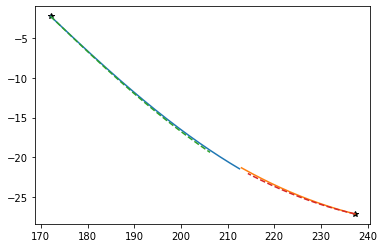

In [9]:
l,b = coords.l,coords.b 
#Corrected trajectory
pmlc,pmbc = correct_gpm(coords.l,coords.b,coords.pm_l_cosb,coords.pm_b,distance=coords.distance)
lsample,bsample,tsample = great_circles_trajectory(l,b,pmlc,pmbc,N=10000,with_time=True,
                             limits=None,start_from_star=True)
#uncorrected trajectory
lunc,bunc,tunc = great_circles_trajectory(l,b,coords.pm_l_cosb/numpy.cos(coords.b),
                                          coords.pm_b,N=10000,with_time=True,
                                          limits=None,start_from_star=True)

tback = 3.1*units.Myr  

pyplot.plot(coords.l,coords.b,"*k")
for l,b,t in zip(lsample,bsample,tsample):
    mask = t < tback 
    pyplot.plot(l[mask],b[mask])


    
for l,b,t in zip(lunc,bunc,tunc):
    mask = t < tback 
    pyplot.plot(l[mask],b[mask],ls="dashed")
